# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [ ]:
# Add any additional import statements you need here



In [27]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Users/smsultanmahmudrahat/Downloads/department/text_minning_dep/week_6/M1_Results"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
# Subfolder paths
twitter_folder = os.path.join(data_location, "twitter/")
lyrics_folder = os.path.join(data_location, "lyrics/")

positive_words_file = "/Users/smsultanmahmudrahat/Downloads/department/text_minning_dep/week_6/M1_Results/positive_words.txt" 
negative_words_file = "/Users/smsultanmahmudrahat/Downloads/department/text_minning_dep/week_6/M1_Results/negative_words.txt"
tidy_text_file = "/Users/smsultanmahmudrahat/Downloads/department/text_minning_dep/week_6/M1_Results/tidytext_sentiments.txt"

In [44]:
with open(tidy_text_file, 'r') as file:
    tidy_text = set(file.read().splitlines())

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [21]:
# Read in the lyrics data

import pandas as pd
lyrics_data = {}

# iterate over files in the lyric folder 

for artist_folder in os.listdir(lyrics_folder):
    artist_path = os.path.join(lyrics_folder, artist_folder)
    
    if os.path.isdir(artist_path):
        # add artist to dict
        lyrics_data[artist_folder] = {}

        for song_file in os.listdir(artist_path):
            song_path = os.path.join(artist_path, song_file)

            with open(song_path, 'r') as file:
                lyrics_data[artist_folder][song_file] = file.read() 

# convert the nested dictionary to a DataFrame for easier handling 
lyrics_df = pd.DataFrame([(artist, song, lyrics) for artist, artist_lyrics in lyrics_data.items() for song, lyrics in artist_lyrics.items()],
                          columns=['artist', 'song', 'lyrics'])

    

In [22]:
lyrics_df.head()

,artist,song,lyrics
0,robyn,robyn_includemeout.txt,"""Include Me Out""\n\n\n\nIt is really very simp..."
1,robyn,robyn_electric.txt,"""Electric""\n\n\n\nElectric...\n\nIt's electric..."
2,robyn,robyn_beach2k20.txt,"""Beach 2K20""\n\n\n\n(So you wanna go out?\nHow..."
3,robyn,robyn_lovekills.txt,"""Love Kills""\n\n\n\nIf you're looking for love..."
4,robyn,robyn_timemachine.txt,"""Time Machine""\n\n\n\nHey, what did I do?\nCan..."


In [23]:
# Read in the twitter data

twitter_data =  []

for twitter_file in os.listdir(twitter_folder):
    twitter_file_path = os.path.join(twitter_folder, twitter_file)
    with open(twitter_file_path, 'r', encoding='utf-8', errors='ignore') as file: 
        lines= file.readlines()
        for line in lines:
            twitter_data.append((twitter_file, line.strip()))

# Convert to DataFrame
twitter_df = pd.DataFrame(twitter_data, columns=['Artist', 'Description'])


In [24]:
twitter_df.shape
twitter_df.head()

,Artist,Description
0,.DS_Store,   Bud1            %                      ...
1,cher_followers_data.txt,screen_name\tname\tid\tlocation\tfollowers_cou...
2,cher_followers_data.txt,hsmcnp\tCountry Girl\t35152213\t\t1302\t1014
3,cher_followers_data.txt,horrormomy\tJeny\t742153090850164742\tEarth\t8...
4,cher_followers_data.txt,anju79990584\tanju\t1496463006451974150\t\t13\...


In [25]:
# Read in the positive and
# negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository.

After you have calculated these sentiments, answer the questions at the end of this section.


In [46]:
# Read positive and negative words
with open(positive_words_file, 'r') as file:
    positive_words = set(file.read().splitlines())

with open(negative_words_file, 'r') as file:
    negative_words = set(file.read().splitlines())

# Combine all sentiment words into a single dictionary
sentiment_words = {word: 1 for word in positive_words}
sentiment_words.update({word: -1 for word in negative_words})

tidy_sentiment_words = {}
with open(tidy_text_file, 'r') as file:
    for line in file:
        word, sentiment, source = line.strip().split('\t')
        if sentiment == 'positive':
            tidy_sentiment_words[word] = 1
        elif sentiment == 'negative':
            tidy_sentiment_words[word] = -1

# Combine the tidy sentiment words with the existing sentiment words
sentiment_words.update(tidy_sentiment_words)

Q: Overall, which artist has the higher average sentiment per song? 

A: Artist with the highest average sentiment per song: cher with a score of 3.161392405063291


In [53]:
lyrics_df = lyrics_df.drop_duplicates(subset=['artist', 'song'])

# Define the sentiment calculation function
def calculate_sentiment(text, sentiment_words):
    words = text.lower().split()
    score = sum(sentiment_words.get(word, 0) for word in words)
    return score

# Apply the sentiment calculation to the lyrics using a lambda function to pass the sentiment_words
lyrics_df['sentiment_score'] = lyrics_df['lyrics'].apply(lambda text: calculate_sentiment(text, sentiment_words))

artist_avg_sentiment = lyrics_df.groupby('artist')['sentiment_score'].mean()
highest_avg_sentiment_artist = artist_avg_sentiment.idxmax()
highest_avg_sentiment_score = artist_avg_sentiment.max()

print(f"Artist with the highest average sentiment per song: {highest_avg_sentiment_artist} with a score of {highest_avg_sentiment_score}")


Artist with the highest average sentiment per song: robyn with a score of 7.673076923076923


Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 


A:

Song: robyn_loveisfree.txt
Sentiment Score: 116

Song: robyn_wedancetothebeat114528.txt
Sentiment Score: 66

Song: robyn_wedancetothebeat.txt
Sentiment Score: 66

Song: robyn_dontfuckingtellmewhattodo.txt
Sentiment Score: -93


Song: robyn_dontfuckingtellmewhattodo114520.txt
Sentiment Score: -93

Song: robyn_criminalintent.txt
Sentiment Score: -53

------


The sentiment scores of Robyn's songs are driven by the frequency and type of words used in the lyrics. The song "Love Is Free" has the highest sentiment score of 116 due to its repetitive use of positive words like "free," "love," and "baby," which create an overall positive and carefree theme. The constant reinforcement of these positive words contributes to the high sentiment score. Similarly, the songs "We Dance To The Beat" also score high (66) because they focus on the positive action of dancing and maintain an energetic, uplifting tone throughout, despite some neutral or slightly negative elements.

On the other hand, the song "Don't Fucking Tell Me What To Do" has the lowest sentiment score of -93, driven by its repetitive use of negative phrases like "killing me" and "don't fucking tell me what to do," which emphasize frustration and negativity. This repetition of negative words significantly lowers the sentiment score. The song "Criminal Intent," with a score of -53, also carries a negative sentiment due to its themes of criminality and defiance, with frequent references to "criminal intent" and other lewd and indecent acts. The overall negative tone and subject matter of these songs drive their low sentiment scores

In [58]:
first_artist = lyrics_df['artist'].unique()[0]
first_artist_songs = lyrics_df[lyrics_df['artist'] == first_artist]

# Get the top 3 highest and lowest sentiment songs
highest_songs = first_artist_songs.nlargest(3, 'sentiment_score')
lowest_songs = first_artist_songs.nsmallest(3, 'sentiment_score')

print(f"Highest sentiment songs for {first_artist}:\n")
for _, row in highest_songs.iterrows():
    print(f"Song: {row['song']}\nSentiment Score: {row['sentiment_score']}\nLyrics:\n{row['lyrics']}\n")

print(f"Lowest sentiment songs for {first_artist}:\n")
for _, row in lowest_songs.iterrows():
    print(f"Song: {row['song']}\nSentiment Score: {row['sentiment_score']}\nLyrics:\n{row['lyrics']}\n")


Highest sentiment songs for robyn:

Song: robyn_loveisfree.txt
Sentiment Score: 116
Lyrics:
"Love Is Free"



Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby
Chica boom chica boom chica boom
Chica boom chica boom chica boom
Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom


Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: 

Song: cher_loveandunderstanding.txt
Sentiment Score: 56

Song: cher_ifoundyoulove.txt
Sentiment Score: 52

Song: cher_perfection.txt
Sentiment Score: 43


Lowest sentiment songs for cher:

Song: cher_bangbang.txt
Sentiment Score: -70

Song: cher_outrageous.txt
Sentiment Score: -26

Song: cher_iwalkonguildedsplinters.txt
Sentiment Score: -24

----------------------
The sentiment scores of Cher's songs are influenced by the positive or negative words and themes present in the lyrics. For example, "Love and Understanding" has the highest sentiment score of 56, driven by its positive message advocating for love and understanding to ease troubled times. Words like "love," "understanding," and "bright" contribute to the positive sentiment. Similarly, "I Found You Love" and "Perfection" score high because they focus on themes of finding true love and striving for excellence, filled with words like "laughter," "wonderful," and "true love."

Conversely, the song "Bang-Bang" has the lowest sentiment score of -70, which is driven by its repeated negative imagery of being shot and experiencing emotional pain. Phrases like "shot me down" and "hit the ground" dominate the lyrics, contributing to the negative sentiment. Other low-scoring songs like "Outrageous" and "I Walk On Guilded Splinters" also carry negative tones. "Outrageous" talks about defiance and rebellion, while "I Walk On Guilded Splinters" includes themes of misfortune, poison, and malice. The frequent use of negative words and darker themes in these songs drives their lower sentiment scores.


In [56]:
second_artist = lyrics_df['artist'].unique()[1]
second_artist_songs = lyrics_df[lyrics_df['artist'] == second_artist]

# Get the top 3 highest and lowest sentiment songs
highest_songs = second_artist_songs.nlargest(3, 'sentiment_score')
lowest_songs = second_artist_songs.nsmallest(3, 'sentiment_score')

print(f"Highest sentiment songs for {second_artist}:\n")
for _, row in highest_songs.iterrows():
    print(f"Song: {row['song']}\nSentiment Score: {row['sentiment_score']}\nLyrics:\n{row['lyrics']}\n")

print(f"Lowest sentiment songs for {second_artist}:\n")
for _, row in lowest_songs.iterrows():
    print(f"Song: {row['song']}\nSentiment Score: {row['sentiment_score']}\nLyrics:\n{row['lyrics']}\n")


Highest sentiment songs for cher:

Song: cher_loveandunderstanding.txt
Sentiment Score: 56
Lyrics:
"Love And Understanding"



Here, here in this world
Where do we go? Where can we turn?
When we need some love
It seems that love just can't be found
Where, where do we stand?
When love's supply don't meet love's demand

We got enough stars to light the sky at night
Enough sun to make to make the whole world bright
We got more than enough
But there's one thing there's just not enough of

Not enough love and understanding
We could use some love to ease these troubled times
Not enough love and understanding
Why, oh why?

Spend all of our time
Building buildings up to the sky
Reaching everywhere
But where we need to reach the most
Hearts never can win
Oh, in this race, this race that we're in

We've got enough cars to drive around the world
Enough planes to take us anywhere
We got more than enough
But there's one thing there's just not enough of

Not enough love and understanding
We could us

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.


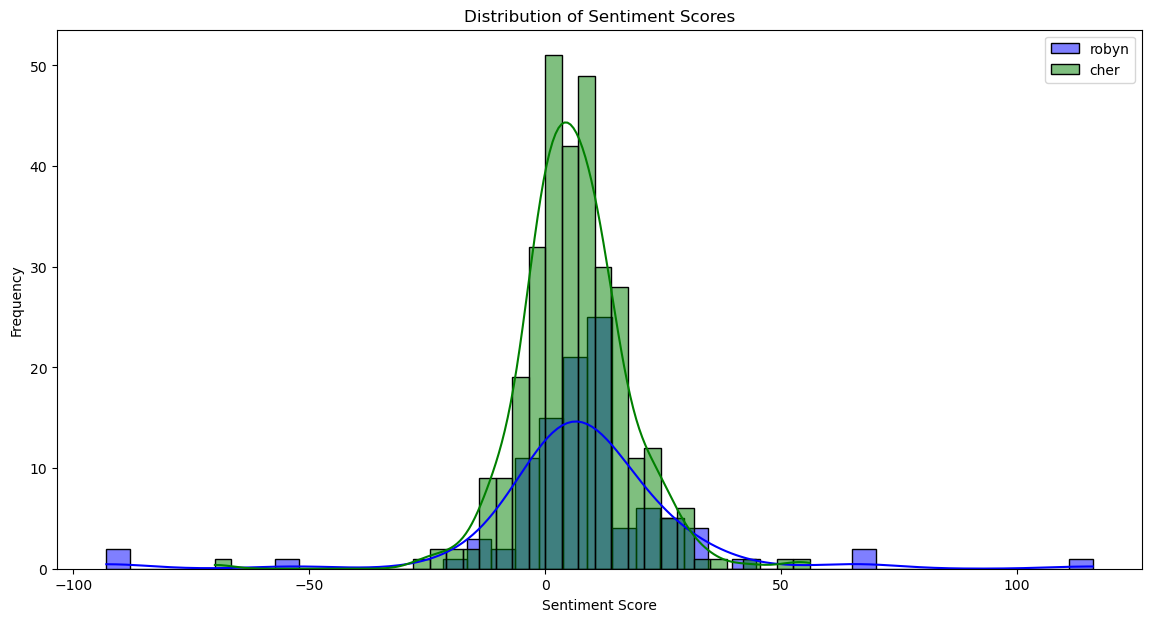

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 7))
sns.histplot(lyrics_df[lyrics_df['artist'] == first_artist]['sentiment_score'], kde=True, color='blue', label=first_artist)
sns.histplot(lyrics_df[lyrics_df['artist'] == second_artist]['sentiment_score'], kde=True, color='green', label=second_artist)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()


## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

Q: What is the average sentiment of your two artists? 

A:

Artist: cher_followers_data.txt, Average Sentiment: 0.35282582074114277


Artist: robynkonichiwa_followers_data.txt, Average Sentiment: 0.28849829646764685

In [61]:
# Define the sentiment calculation function for text
def calculate_sentiment(text, sentiment_words):
    words = text.lower().split()
    score = sum(sentiment_words.get(word, 0) for word in words)
    return score

# Apply the sentiment calculation to the Twitter descriptions
twitter_df['sentiment_score'] = twitter_df['Description'].apply(lambda text: calculate_sentiment(text, sentiment_words))


In [63]:
# Calculate average sentiment for each artist using sentiment_score
artist_avg_sentiment = twitter_df.groupby('Artist')['sentiment_score'].mean()

for artist, avg_sentiment in artist_avg_sentiment.items():
    print(f"Artist: {artist}, Average Sentiment: {avg_sentiment}")


Artist: .DS_Store, Average Sentiment: 0.0
Artist: cher_followers.txt, Average Sentiment: 0.0
Artist: cher_followers_data.txt, Average Sentiment: 0.35282582074114277
Artist: robynkonichiwa_followers.txt, Average Sentiment: 0.0
Artist: robynkonichiwa_followers_data.txt, Average Sentiment: 0.28849829646764685


Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A:

Artist: cher_followers_data.txt, Most Popular Positive Emoji: 😍, Count: 8955 </br>
Artist: cher_followers_data.txt, Most Popular Negative Emoji: 😭, Count: 823 </br>
Artist: robynkonichiwa_followers_data.txt, Most Popular Positive Emoji: 😎, Count: 325 </br>
Artist: robynkonichiwa_followers_data.txt, Most Popular Negative Emoji: 😭, Count: 42

In [67]:
# Function to count emojis
def count_emojis(text, emojis):
    emoji_counts = Counter()
    for char in text:
        if char in emojis:
            emoji_counts[char] += 1
    return emoji_counts

# Initialize dictionaries to store emoji counts for each artist
positive_emoji_counts = defaultdict(Counter)
negative_emoji_counts = defaultdict(Counter)

# Count emojis for each artist
for _, row in twitter_df.iterrows():
    artist = row['Artist']
    description = row['Description']
    positive_emoji_counts[artist] += count_emojis(description, positive_emojis)
    negative_emoji_counts[artist] += count_emojis(description, negative_emojis)

# Find the most popular positive and negative emojis for each artist
most_popular_positive_emoji = {}
most_popular_negative_emoji = {}

for artist, counts in positive_emoji_counts.items():
    if counts:
        most_popular_positive_emoji[artist] = counts.most_common(1)[0]
    else:
        most_popular_positive_emoji[artist] = ('None', 0)

for artist, counts in negative_emoji_counts.items():
    if counts:
        most_popular_negative_emoji[artist] = counts.most_common(1)[0]
    else:
        most_popular_negative_emoji[artist] = ('None', 0)

for artist in most_popular_positive_emoji:
    print(f"Artist: {artist}, Most Popular Positive Emoji: {most_popular_positive_emoji[artist][0]}, Count: {most_popular_positive_emoji[artist][1]}")
    print(f"Artist: {artist}, Most Popular Negative Emoji: {most_popular_negative_emoji[artist][0]}, Count: {most_popular_negative_emoji[artist][1]}")
